In [1]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up parameters, create isochrone grid

In [2]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.MISTv1()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F182M']
filters = ['m_jwst_F115W', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

In [3]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma1p0/fiducial/sfe_ff100/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 1.5)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()

# read ages for simulated stars
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass        isMultiple        compMass            systemMass             e                log_a               age        
------------------- ---------- --------------------- ------------------- ------------------ ------------------ ------------------
  56.24521950614411        0.0                    []   56.24521950614411                nan                nan  1.494411190854979
0.11411525852041825        0.0                    [] 0.11411525852041825                nan                nan 1.5011385289993755
  12.96283688892593        0.0                    []   12.96283688892593                nan                nan 1.4970749668953602
0.27321673034539384        0.0                    [] 0.27321673034539384                nan                nan 1.4964816285263873
                ...        ...                   ...                 ...                ...                ...                ...
0.20449300038109305        1.0 [0.11248395795903553] 0.31697695834012857   0.2989732941710

In [4]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 6.172382928762329
Max log age = 6.182058450993647
Min level age = 1487246.4082493563
Max level age = 1520752.191543579


In [5]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
print(compMasses)

1440
[0.16312509029104827, 0.09636490446440792, 0.03636643773183382, 0.21849298240279427, 0.03651675631669997, 0.019132423710002903, 0.05933243108388687, 0.12247264926103713, 0.6385500001324462, 0.2022302569658592, 0.07471903553293849, 0.16814292142663018, 0.0230523225129767, 0.1609042880961581, 0.2688387764755287, 0.05549755459546917, 0.012694034520736917, 0.09389877662294215, 0.024808470564410257, 0.012916016567435117, 0.537538199511473, 0.10166459547430746, 0.017003778368234634, 0.1895631651814792, 0.011007644292289143, 0.1908368021249771, 0.16246922314167023, 0.09223736189469771, 0.08370963329421344, 0.5588908545309716, 0.03431704460795354, 0.045772770042914156, 0.15501195511789118, 0.026778635366288318, 0.02533061849344048, 0.044663360767730004, 0.05472224588958281, 0.028879488831018898, 0.1309257580510967, 0.11610612932071074, 0.7052331632631441, 0.42965823402192654, 0.09028542237526906, 0.08645685263723765, 0.6922198305107939, 0.5510788138832429, 0.014685248829668424, 0.02854885

In [6]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[6.         6.17609126 6.30103   ]
[1000000. 1500000. 2000000.]


In [7]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

isochrone generation done


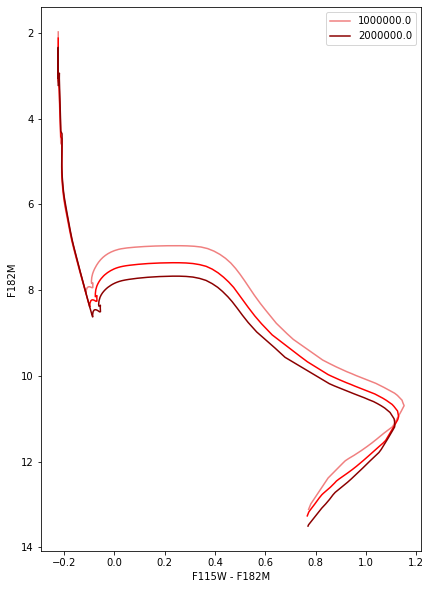

In [8]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

In [9]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/12-18')
import interpolatorOld as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
for i in range(len(stars)):
    print(stars[i])

[502644.0120010004, 45462.866, 4.041, 3.292, 3.51]
[0.06998198669320797, 3008.871, 3.508, 13.906, 13.127]
[12594.262188120356, 28349.669, 4.212, 5.951, 6.143]
[0.20349906991301725, 3357.504, 3.621, 12.909, 11.905]
[0.16258497768339614, 3282.998, 3.606, 13.115, 12.162]
[0.2346253811307548, 3411.722, 3.638, 12.782, 11.748]
[17747.169170169258, 29792.043, 4.199, 5.706, 5.904]
[-517.1197659844579, 2974.239, 3.509, 14.04, 13.272]
[0.2325073897155556, 3407.658, 3.636, 12.79, 11.758]
[0.16856833934066817, 3294.588, 3.608, 13.081, 12.12]
[0.5205243896992225, 3813.872, 3.732, 12.087, 10.958]
[-369.4559270754285, 2976.021, 3.51, 14.042, 13.274]
[-426.40969191474676, 2975.121, 3.507, 14.035, 13.267]
[-132.2979164972086, 2978.622, 3.509, 14.038, 13.27]
[0.07556486078845455, 3029.108, 3.514, 13.833, 13.041]
[-1217.7105428140685, 2966.175, 3.509, 14.042, 13.273]
[2235.579276643757, 21783.413, 4.275, 7.094, 7.245]
[0.2504968831515195, 3435.14, 3.64, 12.723, 11.676]
[-210.9113894565549, 2977.704, 3.50

[0.21275588090437317, 3375.151, 3.628, 12.87, 11.856]
[-1394.4021615586535, 2964.133, 3.508, 14.041, 13.272]
[-630.2318909963083, 2972.806, 3.507, 14.034, 13.266]
[-1027.2852828195153, 2968.306, 3.506, 14.034, 13.266]
[0.5864824635064774, 3880.403, 3.743, 11.98, 10.853]
[0.14845867214479944, 3245.892, 3.588, 13.195, 12.27]
[0.1345117624665789, 3215.382, 3.582, 13.286, 12.388]
[0.10480340688023902, 3125.245, 3.544, 13.52, 12.675]
[0.33334943034285996, 3566.495, 3.671, 12.472, 11.381]
[-206.55557150541986, 2977.623, 3.507, 14.034, 13.265]
[0.11333579647483663, 3155.29, 3.558, 13.446, 12.585]
[-1376.465769800383, 2964.338, 3.508, 14.041, 13.272]
[4.375252937732633, 4982.544, 3.802, 10.081, 9.379]
[0.33115670079800824, 3567.534, 3.675, 12.479, 11.388]
[-1844.5016630136574, 2958.973, 3.508, 14.042, 13.273]
[-1847.2844973321812, 2958.942, 3.508, 14.042, 13.273]
[0.10362116904439285, 3121.281, 3.543, 13.531, 12.688]
[0.11393184201195404, 3157.151, 3.559, 13.441, 12.579]
[-446.54183375104554, 

In [10]:
# perform interpolation on companion stars
companions = np.empty(len(compMasses), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None:
        continue
    companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

for i in range(len(companions)):
    if companions[i] is None:
        continue
    companions[i][0] = companions[i][0] * watts_to_lsun
    
for i in range(len(companions)):
    if companions[i] is None:
        continue
    print(companions[i])

[0.1077660190313135, 3139.086, 3.555, 13.496, 12.643]
[-133.35170637104858, 2978.858, 3.511, 14.044, 13.276]
[-1333.0823097247994, 2964.896, 3.511, 14.047, 13.279]
[0.15179053891783353, 3259.793, 3.6, 13.178, 12.243]
[-1330.0765361389292, 2964.931, 3.511, 14.047, 13.279]
[-1677.6940167676173, 2960.885, 3.511, 14.048, 13.28]
[-873.8538233755233, 2970.24, 3.511, 14.046, 13.278]
[0.07564632513338615, 3030.81, 3.517, 13.833, 13.041]
[0.6729815216784678, 3961.947, 3.759, 11.853, 10.739]
[0.13858123416174503, 3227.684, 3.589, 13.261, 12.352]
[-566.1829570264058, 2973.821, 3.511, 14.045, 13.277]
[0.11142262083640708, 3151.666, 3.56, 13.464, 12.605]
[-1599.3116378153898, 2961.797, 3.511, 14.048, 13.279]
[0.10612161221770854, 3133.324, 3.552, 13.51, 12.661]
[0.19720040786839357, 3350.333, 3.625, 12.94, 11.942]
[-950.536094336433, 2969.348, 3.511, 14.046, 13.278]
[-1806.4361824813031, 2959.387, 3.511, 14.048, 13.28]
[-182.66445058383056, 2978.284, 3.511, 14.044, 13.276]
[-1564.19566442311, 2962.

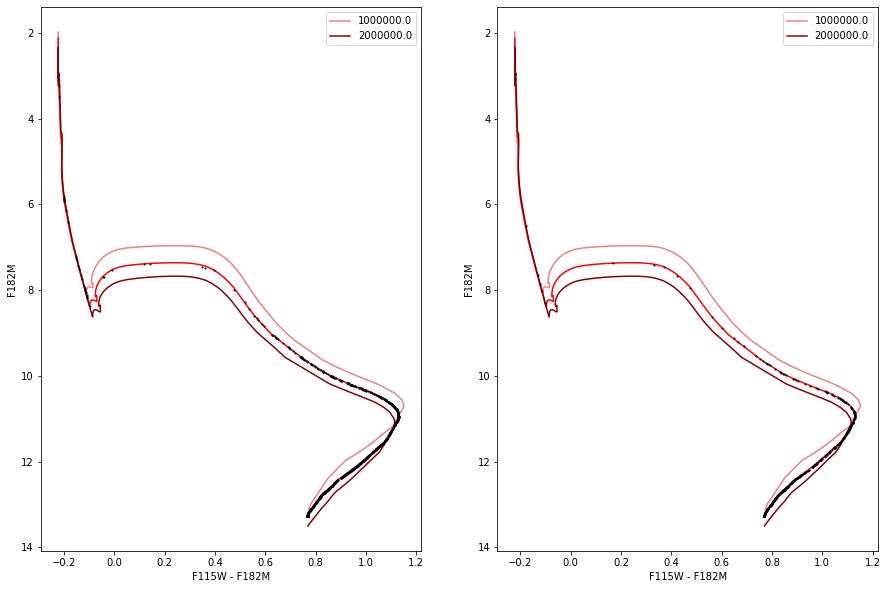

In [11]:
# plot primaries and companions separately
fig, axes = py.subplots(figsize=(15, 10))

# plot primaries
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

# plot companions
py.subplot(1, 2, 2)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
        
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

In [12]:
# combine magnitudes on binary stars
unresolved_binaries = np.empty(len(companions), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None or companions[i] is None:
        continue
        
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.6e-8
    flux21 = np.power(10, companions[i][3] / -2.5) * 3.6e-8
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.6e-8)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 3.6e-8
    flux22 = np.power(10, companions[i][4] / -2.5) * 3.6e-8
    mag2 = -2.5 * np.log10((flux12 + flux22) / 3.6e-8)
    
    unresolved_binaries[i] = [mag1, mag2]

for i in range(len(unresolved_binaries)):
    print(unresolved_binaries[i])

[12.199240880159682, 11.184608530964091]
[12.839549172217346, 11.97784628722485]
[13.293924895710795, 12.525924895710798]
[11.839067264338496, 10.76979314053871]
[13.294425010840047, 12.525924895710798]
[13.294424550323091, 12.526424550323092]
[13.292424550323094, 12.524424550323094]
[12.988322113458231, 12.182187543830565]
[10.398301299994845, 9.487822696021052]
[11.958657846627041, 10.908352862148432]
[13.240227646295981, 12.468032542245986]
[12.664450848215107, 11.795507120620472]
[13.293423168773016, 12.524923974677085]
[12.361776365575366, 11.394724120542943]
[11.95783699674584, 10.90659618538517]
[12.89973351195857, 12.057405327084433]
[13.294924895710798, 12.526924895710795]
[12.818674746300104, 11.949791943317932]
[13.293423168773016, 12.524923974677085]
[13.283425010840046, 12.514425010840046]
[10.818529936659282, 9.803760646216169]
[12.683008351769555, 11.765447906896352]
[13.294424550323091, 12.526424550323092]
[12.015834430227954, 10.974050516952849]
[13.295425010840047, 12

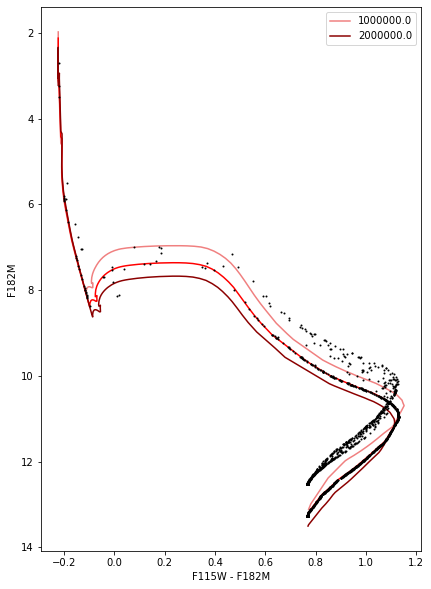

In [13]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
for i in range(len(unresolved_binaries)):
    if unresolved_binaries[i] is None:
        continue
    py.plot(unresolved_binaries[i][0] - unresolved_binaries[i][1], unresolved_binaries[i][1], marker='o', markersize=1, color='k')